
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)
## Vehicle Detection & Tracking Pipeline

In this project, your goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4), but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup template](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) for this project and use it as a starting point for creating your own writeup.  

The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

### Dataset - Load Data and Extract Features

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image
import time
import os
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
## Dataset Parameters ##
LABELS_CSV = 'FILL_LATER.csv'
TRAINING_DATASET_DIRECTORY = 'training_set/'
PIPELINE_SETUP_DIRECTORY = 'pipeline_setup_images/'
WORKING_DIRECTORY = 'data/'
NON_VEHICLES_TOKEN = 'non-vehicles'
dataset_path = "{}{}{}{}".format(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY,'**/', '*.png')
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')

## Image Processing ##
DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH = (64, 64, 3)
if DEFAULT_DEPTH > 1:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH)
else:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH)

## Feature Extraction Parameters ##
# Spatial Binning
SPATIAL = 16
BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
HIST_NBINS = 128
COLOR_SPACE = 'YUV'
# HOG Parameters
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = 8
HOG_CELLS_PER_BLOCK = 2
HOG_CHANNEL = 'ALL' # Can be 0, 1, 2, or "ALL"

# SVC Parameters
VALIDATION_PORTION = .3
N_PREDICTIONS = 100

In [3]:
# Define a function to scale .PNG and JPEG Files both to 0 to 1 
def normalize_pixels(img):
    max_pixel_value = np.max(img)
    if max_pixel_value > 1.0:
        img = np.copy(np.multiply(img, 1.0 / 255.0)).astype(np.float64) 
    return img

# Define a function to scale .PNG and JPEG Files both to 0 to 1 
def denormalize_pixels(img):
    max_pixel_value = np.max(img)
    if max_pixel_value <= 1.0:
        img = np.copy(np.multiply(img, 255.0)).astype(np.float64) 
    return img

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=BIN_SPATIAL_SIZE):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3)) 


In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=HIST_NBINS):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [6]:
# Define a function to return HOG features and visualization --
def get_hog_features(img, orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL,
                     cell_per_block=HOG_CELLS_PER_BLOCK, vis=False, feature_vec=True):      
    denormalized_img = denormalize_pixels(img)
    if vis == True:
        features, hog_image = hog(denormalized_img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(denormalized_img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [7]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace=COLOR_SPACE, spatial_size=BIN_SPATIAL_SIZE,
                        hist_bins=HIST_NBINS):
    # Create a list to append feature vectors
    features = []
    for file in imgs:
        image = mpimg.imread(file)

        # Image read in from mpimg + .png -> (0 to 1) scaled
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_image = np.copy(image)
        hog_shape = np.asarray(hog_image.shape)
        if HOG_CHANNEL == 'ALL':
            hog_features = []
            for channel in range(len(hog_shape)):
                hog_features.append(get_hog_features(hog_image[:,:,channel]))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(hog_image[:,:,HOG_CHANNEL])
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [8]:
## Starting Training Pipeline ##
# Load Image Paths 
images = glob.glob(dataset_path, recursive=True)
cars = []
notcars = []
for image in images:
    if NON_VEHICLES_TOKEN in image:
        notcars.append(image)
    else:
        cars.append(image)
print('Number of Vehicle Images Found:',len(cars),'(images in directory):', dataset_path)
print('Number of Non-Vehicle Images Found:',len(notcars),'(images in directory):', dataset_path)
assert len(images) == len(cars) + len(notcars), 'The subarrays have not split the dataset correctly.'

Number of Vehicle Images Found: 8792 (images in directory): data/training_set/**/*.png
Number of Non-Vehicle Images Found: 8968 (images in directory): data/training_set/**/*.png


Feature Vector size for Cars: 6444
Using Spatial Binning of: 16 and 128 histogram bins


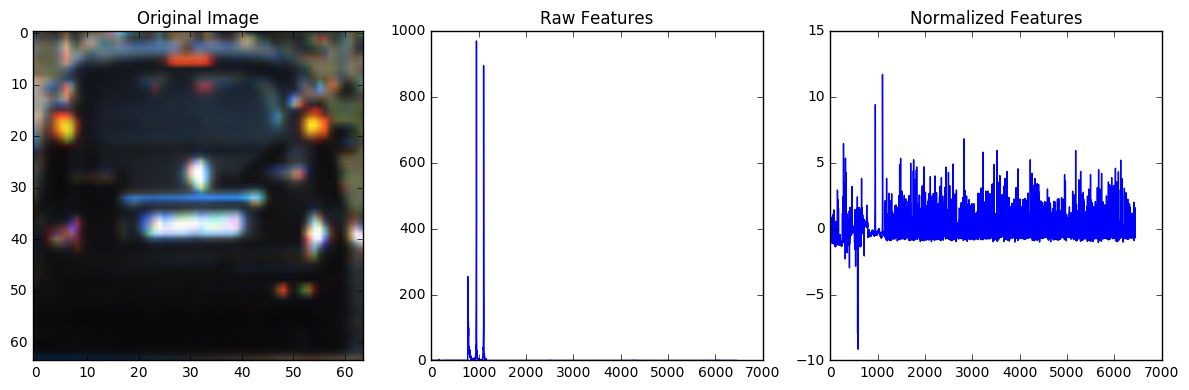

In [9]:
# Start Pipeline - Combine and Normalilze Features
car_features = extract_features(cars)
notcar_features = extract_features(notcars)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

print('Feature Vector size for Cars:', len(car_features[car_ind]))
print('Using Spatial Binning of:',BIN_SPATIAL_SIZE[0],
    'and', HIST_NBINS,'histogram bins')

In [10]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [11]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=VALIDATION_PORTION, random_state=rand_state)
print('Feature vector length:', len(X_train[0]))

Feature vector length: 6444


In [12]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = N_PREDICTIONS
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

33.34 Seconds to train SVC...
Test Accuracy of SVC =  0.9891
My SVC predicts:  [ 1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  1.  1.  0.  0.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.
  1.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  1.
  0.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.
  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.]
For these 100 labels:  [ 1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  1.  1.  0.  1.  1.
  1.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  1.  1.
  0.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.
  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.]
0.0769 Seconds to predict 100 labels with SVC


In [13]:
#Save Support Vector Classifier to Datacache
def save_to_datacache(support_vector_classifier, datacache_dir=DATACACHE_DIRECTORY):
    os.makedirs(datacache_dir, exist_ok=True)
    svc_pickle = os.path.join(datacache_dir,"svc_pickle.p")
    if not os.path.exists(svc_pickle): 
        svc_hyperparameters = {'svc': svc,
                               'X_scaler':X_scaler,
                               'SPATIAL': SPATIAL, 
                               'HIST_NBINS': HIST_NBINS,
                               'COLOR_SPACE': COLOR_SPACE,
                               'HOG_ORIENTATIONS': HOG_ORIENTATIONS,
                               'HOG_PIXELS_PER_CELL': HOG_PIXELS_PER_CELL,
                               'HOG_CELLS_PER_BLOCK': HOG_CELLS_PER_BLOCK,
                               'HOG_CHANNEL': HOG_CHANNEL
                              }

        pickle.dump(svc_hyperparameters, open(svc_pickle, "wb"))
    
# Save classifier and parameters to datacache directory  
save_to_datacache(svc)

# Finished Training SVC - Now to Utilize Sliding Windows

In [14]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

In [76]:
# Sliding Window Constants
WORKING_DIRECTORY = 'data/'
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')
svc_pickle = os.path.join(DATACACHE_DIRECTORY,"svc_pickle.p")
TESTING_DATASET_DIRECTORY = 'testing_dataset/'
TESTING_PIPELINE_SETUP_DIR= 'test_images/'

testset_path = "{}{}{}".format(WORKING_DIRECTORY, TESTING_PIPELINE_SETUP_DIR, '*.jpg')


with open(svc_pickle, mode='rb') as f:
    svc_hyperparameters = pickle.load(f)
    
    
## Feature Extraction Parameters ##
# Spatial Binning
SVC = svc_hyperparameters['svc']
X_SCALER = svc_hyperparameters['X_scaler']
SPATIAL = svc_hyperparameters['SPATIAL']

BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
HIST_NBINS = svc_hyperparameters['HIST_NBINS']
COLOR_SPACE = svc_hyperparameters['COLOR_SPACE']
# HOG Parameters
HOG_ORIENTATIONS = svc_hyperparameters['HOG_ORIENTATIONS']
HOG_PIXELS_PER_CELL = svc_hyperparameters['HOG_PIXELS_PER_CELL']
HOG_CELLS_PER_BLOCK = svc_hyperparameters['HOG_CELLS_PER_BLOCK']
HOG_CHANNEL = svc_hyperparameters['HOG_CHANNEL'] # Can be 0, 1, 2, or "ALL"

## Verify SVC loaded ##
print('svc', SVC)
print('X_scaler', X_SCALER)

BBOX_COLOR = (0, 0, 255)
BBOX_THICK = 6

## Sliding Windows Parameters - Horizon ##
SW_YSTART_HORIZON = 350
SW_YSTOP_HORIZON = 542
SW_XY_WINDOW_HORIZON = 96
SW_XY_OVERLAP_HORIZON = 0.75

## Sliding Windows Parameters - Foreground ##
SW_YSTART_FOREGROUND = 355
SW_YSTOP_FOREGROUND = 670
SW_XY_WINDOW_FOREGROUND = 192
SW_XY_OVERLAP_FOREGROUND = 0.50

SW_SPATIAL_FEAT_FLAG = True
SW_HOG_FEAT_FLAG = True
SW_COLOR_HIST_FEAT_FLAG = True

svc LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
X_scaler StandardScaler(copy=True, with_mean=True, with_std=True)


In [112]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=BBOX_COLOR, thick=BBOX_THICK):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [113]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

In [114]:
#Define a function for plotting multipole images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [115]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space=COLOR_SPACE, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [116]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, svc=SVC, X_scaler=X_SCALER, color_space=COLOR_SPACE, 
                    spatial_size=BIN_SPATIAL_SIZE, hist_bins=HIST_NBINS, 
                    orient=HOG_ORIENTATIONS, pix_per_cell=HOG_PIXELS_PER_CELL, cell_per_block=HOG_CELLS_PER_BLOCK, 
                    hog_channel=HOG_CHANNEL, spatial_feat=SW_SPATIAL_FEAT_FLAG, 
                    hist_feat=SW_COLOR_HIST_FEAT_FLAG, hog_feat=SW_HOG_FEAT_FLAG):
    

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (DEFAULT_LENGTH, DEFAULT_WIDTH))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = svc.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1: # Car detected
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [117]:
# Try Scaling Windows on Test Images

image_paths = glob.glob(testset_path, recursive=True)
print('Found',len(image_paths),'images in directory:', testset_path)

Found 6 images in directory: data/test_images/*.jpg


BBoxes Found - Horizon: 6
BBoxes Found - Foreground: 5
2.270137071609497 seconds to process one image search 375 windows
BBoxes Found - Horizon: 8
BBoxes Found - Foreground: 2
2.21146297454834 seconds to process one image search 375 windows
BBoxes Found - Horizon: 2
BBoxes Found - Foreground: 0
2.238880157470703 seconds to process one image search 375 windows
BBoxes Found - Horizon: 4
BBoxes Found - Foreground: 8
2.2927451133728027 seconds to process one image search 375 windows
BBoxes Found - Horizon: 3
BBoxes Found - Foreground: 3
2.3694570064544678 seconds to process one image search 375 windows
BBoxes Found - Horizon: 5
BBoxes Found - Foreground: 4
3.0184497833251953 seconds to process one image search 375 windows


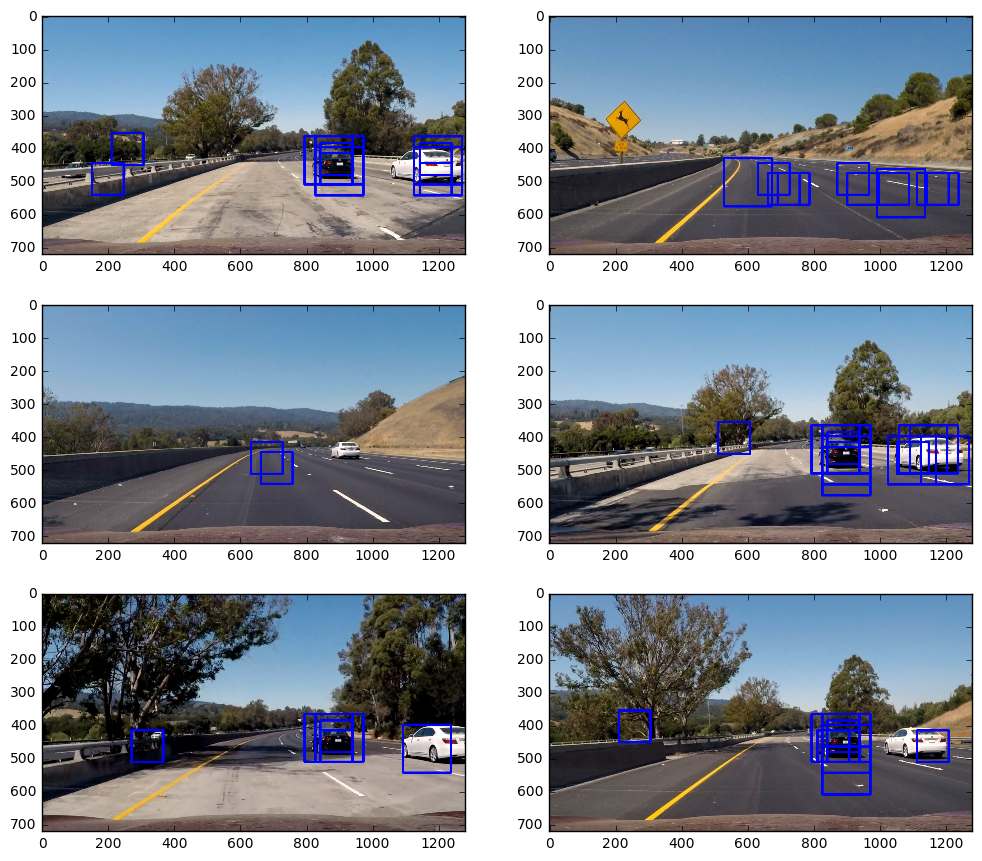

In [176]:
# Define a single function that can extract features using hog sub-sampling and make predictions
images = []

titles = []
## Sliding Windows Parameters - Horizon ##
SW_YSTART_HORIZON = 355
SW_YSTOP_HORIZON = 570
SW_XY_WINDOW_HORIZON = 96
SW_XY_OVERLAP_HORIZON = 0.68

## Sliding Windows Parameters - Foreground ##
SW_YSTART_FOREGROUND = 365
SW_YSTOP_FOREGROUND = 670
SW_XY_WINDOW_FOREGROUND = 145
SW_XY_OVERLAP_FOREGROUND = 0.770


y_start_stop_horizon = [SW_YSTART_HORIZON, SW_YSTOP_HORIZON] # Min/Max in y to search in slide_window()
y_start_stop_foreground = [SW_YSTART_FOREGROUND, SW_YSTOP_FOREGROUND] # Min/Max in y to search in slide_window()

for img_path in image_paths:
    t1 = time.time()
    img = mpimg.imread(img_path)
    draw_img = np.copy(img)
    img = normalize_pixels(img).astype(np.float32)
    windows = []
    hot_windows = []
    
    
    # Horizon Check
    windows_1 = slide_window(img, x_start_stop=[None,None], y_start_stop=y_start_stop_horizon, 
                           xy_window=(SW_XY_WINDOW_HORIZON,SW_XY_WINDOW_HORIZON), 
                           xy_overlap=(SW_XY_OVERLAP_HORIZON,SW_XY_OVERLAP_HORIZON))

    hot_windows_1 = search_windows(img, windows_1, SVC, X_SCALER, color_space=COLOR_SPACE,
                                 spatial_size=BIN_SPATIAL_SIZE, hist_bins=HIST_NBINS, orient=HOG_ORIENTATIONS,
                                 pix_per_cell=HOG_PIXELS_PER_CELL, cell_per_block=HOG_CELLS_PER_BLOCK,
                                 hog_channel=HOG_CHANNEL, spatial_feat=SW_SPATIAL_FEAT_FLAG, hog_feat=SW_HOG_FEAT_FLAG,
                                 hist_feat=SW_COLOR_HIST_FEAT_FLAG)

    print('BBoxes Found - Horizon:', len(hot_windows_1))
    windows.extend(windows_1)
    hot_windows.extend(hot_windows_1)
    
    # Foreground Check
    windows_2 = slide_window(img, x_start_stop=[None,None], y_start_stop=y_start_stop_foreground, 
                           xy_window=(SW_XY_WINDOW_FOREGROUND,SW_XY_WINDOW_FOREGROUND), 
                           xy_overlap=(SW_XY_OVERLAP_FOREGROUND,SW_XY_OVERLAP_FOREGROUND))

    hot_windows_2 = search_windows(img, windows_2, SVC, X_SCALER, color_space=COLOR_SPACE,
                                 spatial_size=BIN_SPATIAL_SIZE, hist_bins=HIST_NBINS, orient=HOG_ORIENTATIONS,
                                 pix_per_cell=HOG_PIXELS_PER_CELL, cell_per_block=HOG_CELLS_PER_BLOCK,
                                 hog_channel=HOG_CHANNEL, spatial_feat=SW_SPATIAL_FEAT_FLAG, hog_feat=SW_HOG_FEAT_FLAG,
                                 hist_feat=SW_COLOR_HIST_FEAT_FLAG)


    print('BBoxes Found - Foreground:', len(hot_windows_2))
    windows.extend(windows_2)
    hot_windows.extend(hot_windows_2)

    window_img = draw_boxes(draw_img, hot_windows, color=BBOX_COLOR, thick=BBOX_THICK)
    images.append(window_img)
    titles.append('')
    
    print(time.time()-t1, 'seconds to process one image search', len(windows), 'windows')
    
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)